Notebook for testing `tproptflow.py` --- the tensorflow impelemntation of difference target propagation

Things to troubleshoot systematically
- noise_inj, including setting it to 0
- dtp_method
    - vanilla
    - difference
    - regularized
- activations (esp see it fail in dtp / vanilla)
- backprop
- simple model: linear or logistic regression
- beta (reg parameter on reg targ prop)

Make sure g_full works in a simple linear regression task. it should...

we know the form of g_full for the constrained problem (LS2) as well as the unconstrained problem (LS3). Both can be parametrized by $V[y, x_0]$. So, we should be good there. We also know the form for vector addition. But what about them together -- affine. Do we know the formula there? And if so does it fit into $V[y, x_0]$? And lastly, of course, what about nonlinear -- how much does it fail for the activation function? Then how does it fail for the full $f_i$?

For the linear one, it doesn't matter if we make $g$ a function of $x_0, y$ or $x_0, f(x), y$ because $f(x)$ can be written in terms of $x_0$ linearly. But for nonlinear $f$ maybe we need $g(x_0, f(x_0), y)$.

Check that $g$ really is acting as an inverse to $f$...

Initialize weight matrix to the DTP solution...

In [28]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import sys
sys.path.append('../')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from toy_data import *
from tproptflow import *


###
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO

from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML



In [30]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [99]:
# Default parameters
batch_size=100
t_steps=50001
layers=4
alpha=0.5
beta0=1.
beta1=1.
beta2=0.0001
noise_str = 0.1
learning_rate=0.0001
dtp_method=1
return_sess=True

In [100]:
sess = run_tprop(batch_size=batch_size,
                 t_steps=t_steps,
                 layers=layers,
                 alpha=alpha,
                 beta0=beta0,
                 beta1=beta1,
                 beta2=beta2,
                 learning_rate=learning_rate,
                 dtp_method=dtp_method,
                 return_sess=return_sess)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Run: 9
iter: 0000 | TRAINING  loss: 2.3619 accuracy: 0.0900 | TEST  loss: 2.3646 accuracy: 0.0853
iter: 1000 | TRAINING  loss: 2.0676 accuracy: 0.3100 | TEST  loss: 2.0621 accuracy: 0.3154
iter: 2000 | TRAINING  loss: 2.0971 accuracy: 0.2800 | TEST  loss: 2.1039 accuracy: 0.2758
iter: 3000 | TRAINING  loss: 1.8777 accuracy: 0.4300 | TEST  loss: 1.9002 accuracy: 0.4118
iter: 4000 | TRAINING  loss: 2.0848 accuracy: 0.2600 | TEST  loss: 2.0145 accuracy: 0.3034
iter: 5000 | TRAINING  loss: 2.0917 accuracy: 0.2600 | TEST  loss: 1.9952 accuracy: 0.3316
iter: 6000 | TRAINING  loss: 1.7890 accuracy: 0.3600 | TEST

In [84]:
from scipy import linalg

In [92]:
linalg.orth(np.random.randn(5,2))

array([[-0.36346071, -0.34791747],
       [ 0.30911746, -0.20340119],
       [ 0.1359836 , -0.84271718],
       [-0.18836013, -0.35643698],
       [ 0.84756807, -0.0190218 ]])

In [20]:
# recover relevant tensors
x1 = tf.get_default_graph().get_tensor_by_name("f1:0")
x2 = tf.get_default_graph().get_tensor_by_name("f2:0")
x3 = tf.get_default_graph().get_tensor_by_name("f3:0")

#x1_ = tf.get_default_graph().get_tensor_by_name("xtar1:0")
#x2_ = tf.get_default_graph().get_tensor_by_name("xtar2:0")
#x3_ = tf.get_default_graph().get_tensor_by_name("xtar3:0")

L3 = tf.get_default_graph().get_tensor_by_name("global_loss:0")
L2 = tf.get_default_graph().get_tensor_by_name("L2:0")
L1 = tf.get_default_graph().get_tensor_by_name("L1:0")

L_inv3 = tf.get_default_graph().get_tensor_by_name("L_inv3:0")
L_inv2 = tf.get_default_graph().get_tensor_by_name("L_inv2:0")


KeyError: "The name 'f3:0' refers to a Tensor which does not exist. The operation, 'f3', does not exist in the graph."

In [372]:
mnist = mnist_data()
x_batch, y_batch = mnist.next_batch(batch_size)
feed_dict = {'x_in:0': x_batch, 'y:0': y_batch, 'epoch:0': 100}

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [384]:
L_ = tf.nn.softmax_cross_entropy_with_logits(x3, y_batch)
tf.gradients(L_, [x3])

[<tf.Tensor 'gradients_6/Reshape_3_grad/Reshape:0' shape=(100, 10) dtype=float32>]

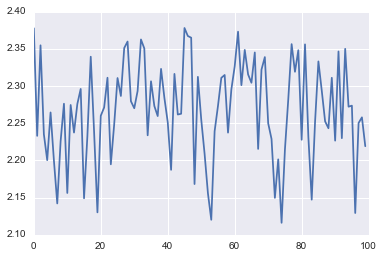

In [377]:
sess.run(tf.nn.softmax_cross_entropy_with_logits(x3, y_batch), feed_dict=feed_dict)

In [365]:
sess.run(L2, feed_dict=feed_dict)

1.1136533e-09

In [366]:
np.mean(0.5*sess.run(x2 - x2_, feed_dict=feed_dict)**2)

1.1136528e-09

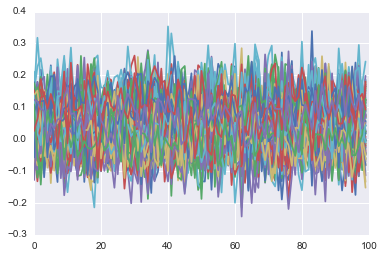

In [368]:
plt.plot(sess.run(x2_, feed_dict=feed_dict))
plt.show()

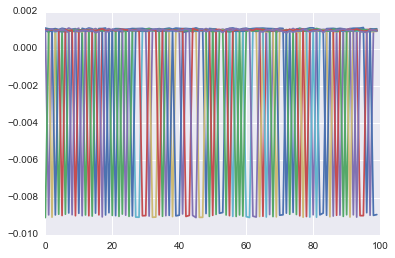

In [295]:
sess.run(tf.gradients(global_loss, [xtop]), feed_dict=feed_dict)[0]

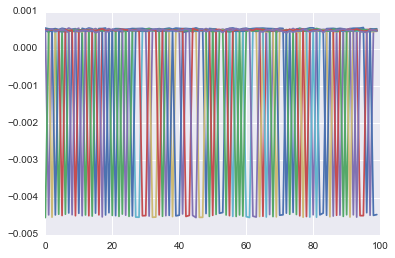

In [278]:
plt.plot(sess.run(top_grad, feed_dict=feed_dict))
plt.show()

In [42]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

[u'x_in',
 u'y',
 u'epoch',
 u'div/y',
 u'div',
 u'add/x',
 u'add',
 u'div_1/x',
 u'div_1',
 u'Layer1/b',
 u'Layer1/b/Initializer/Const',
 u'Layer1/b/Assign',
 u'Layer1/b/read',
 u'Layer1/W',
 u'Layer1/W/Initializer/random_uniform/shape',
 u'Layer1/W/Initializer/random_uniform/min',
 u'Layer1/W/Initializer/random_uniform/max',
 u'Layer1/W/Initializer/random_uniform/RandomUniform',
 u'Layer1/W/Initializer/random_uniform/sub',
 u'Layer1/W/Initializer/random_uniform/mul',
 u'Layer1/W/Initializer/random_uniform',
 u'Layer1/W/Assign',
 u'Layer1/W/read',
 u'Layer2/b',
 u'Layer2/b/Initializer/Const',
 u'Layer2/b/Assign',
 u'Layer2/b/read',
 u'Layer2/W',
 u'Layer2/W/Initializer/random_uniform/shape',
 u'Layer2/W/Initializer/random_uniform/min',
 u'Layer2/W/Initializer/random_uniform/max',
 u'Layer2/W/Initializer/random_uniform/RandomUniform',
 u'Layer2/W/Initializer/random_uniform/sub',
 u'Layer2/W/Initializer/random_uniform/mul',
 u'Layer2/W/Initializer/random_uniform',
 u'Layer2/W/Assign',
 

In [44]:
adm = tf.train.AdamOptimizer(0.1)

In [ ]:
adm.minimize()

In [211]:
[v.name for v in tf.global_variables()]

[u'Layer1/b:0',
 u'Layer1/W:0',
 u'Layer2/b:0',
 u'Layer2/W:0',
 u'Layer3/b:0',
 u'Layer3/W:0',
 u'Layer3/c:0',
 u'Layer3/V:0',
 u'Layer2/c:0',
 u'Layer2/V:0',
 u'Layer1/blah:0',
 u'Layer1//blah:0',
 u'.Layer1/blah:0',
 u'./Layer1/blah:0',
 u'Layer1/blah2:0']

In [212]:
tf.get_default_graph()._name_stack

''

In [194]:
sess.run(tf.global_variables()[-1])

array([[-0.06230563, -0.05338584, -0.05060213, ..., -0.05330393,
        -0.05168646, -0.05314264],
       [-0.02673309, -0.01819305,  0.07483278, ..., -0.04553087,
        -0.06732748, -0.05738726],
       [ 0.04246403, -0.00633399, -0.03595097, ...,  0.01851398,
         0.04568848,  0.03198643],
       ..., 
       [-0.02945174,  0.02242867,  0.02873576, ...,  0.00685532,
         0.00671942,  0.03994024],
       [-0.06139756,  0.02967765, -0.01797304, ..., -0.00280326,
         0.0677508 , -0.0597601 ],
       [-0.06109872, -0.00814603,  0.00118754, ...,  0.00015386,
         0.04672119,  0.01606834]], dtype=float32)

In [154]:
show_graph(tf.get_default_graph())

In [155]:
tf.reset_default_graph()

In [239]:
blah = (5)*[None]


In [251]:
with tf.variable_scope('blah') as blah[1]:
  print('what')

what


'blah'